In [1]:
import torch as t
from train_mnist import CNN
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from tqdm import tqdm
from train_mnist import load_pure_number_pattern_data
import numpy as np

In [2]:
model = CNN(input_size=28)
model.load_state_dict(t.load("model_final_finetuned.ckpt"))
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model.to(device)
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=294, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (relu): ReLU()
)

In [3]:
conv1 = model.conv1[0].weight.detach().cpu().numpy()
conv2 = model.conv2[0].weight.detach().cpu().numpy()
print(conv1.shape)
print(conv2.shape)


(6, 1, 3, 3)
(6, 6, 3, 3)


In [6]:
fc1 = model.fc1.weight.detach().cpu().numpy()
fc2 = model.fc2.weight.detach().cpu().numpy()
print(fc1.shape)
print(fc2.shape)

(10, 294)
(10, 10)


In [15]:
plt.figure(figsize=(fc1.shape[1] * 2, fc1.shape[0] * 2))
plt.imshow(fc1, cmap='gray')

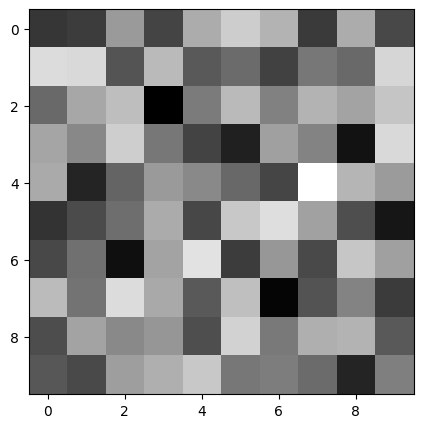

In [18]:
plt.figure(figsize=(5, 5))
plt.imshow(fc2, cmap='gray')

In [80]:
def visualize_weights(weights, title=""):
    # Number of filters
    num_filters = weights.shape[0]
    
    # Number of input channels per filter
    input_channels = weights.shape[1]
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(num_filters, input_channels, figsize=(2*input_channels, 2*num_filters))
    
    # Iterate through the filters and input channels
    for i in range(num_filters):
        for j in range(input_channels):
            ax = axes[i, j] if input_channels > 1 else axes[i]
            ax.imshow(weights[i, j], cmap="gray") # Displaying as grayscale image
            ax.axis('on') # Show axis
            
            # Set the title for each subplot
            ax.set_title(f"Filter {i + 1}, Channel {j + 1}")
            
            # Remove the ticks on the axis for cleaner visualization
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.suptitle(title, y=1.05)  # Adjust y value to fit the main title better
    plt.show()

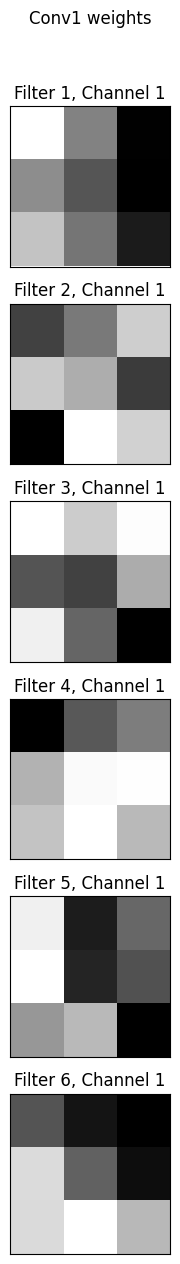

In [81]:
visualize_weights(conv1, title="Conv1 weights")

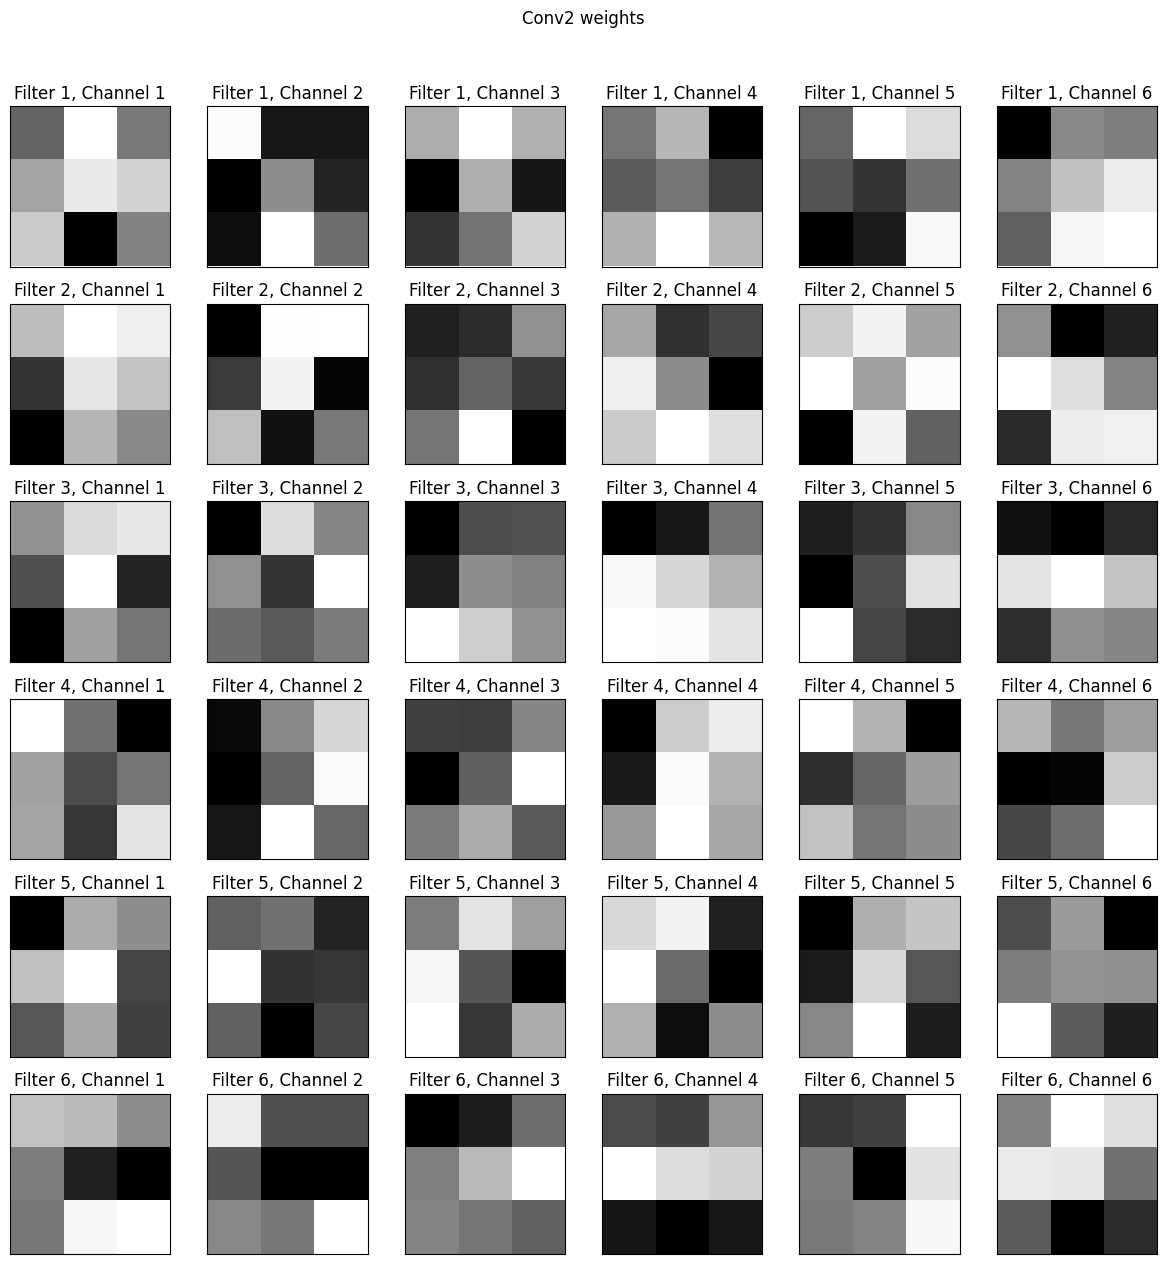

In [82]:
visualize_weights(conv2, title="Conv2 weights")

In [83]:

def create_maximally_activating_image(model, layer_name, kernel_index, image_size=(56, 56), num_iterations=200, lr=0.1):
    # Create a random noise image with the specified size
    image = t.randn(1, 1, *image_size, requires_grad=True, device="cuda")
    optimizer = t.optim.Adam([image], lr=lr)

    model.to("cuda").eval()

    for iteration in tqdm(range(num_iterations)):
        optimizer.zero_grad()
        
        # Forward pass through the specified layer
        x = image
        for name, layer in model.named_children():
            x = layer(x)
            if name == layer_name:
                break
        
        # Maximize the activation of the specific kernel
        loss = -x[0, kernel_index].mean()
        loss.backward()
        optimizer.step()
        
        # Clip the values of the image to keep them between 0 and 1
        image.data.clamp_(0, 1)

    return image.detach()

def visualize_activations(model, layer_name, image_size=(28, 28)):
    num_kernels = dict(model.named_children())[layer_name][0].out_channels

    fig, axes = plt.subplots(1, num_kernels, figsize=(20, 20))
    
    for i in range(num_kernels):
        img = create_maximally_activating_image(model, layer_name, i, image_size)
        ax = axes[i]
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Kernel {i + 1}')

    plt.show()


100%|██████████| 200/200 [00:00<00:00, 629.18it/s]


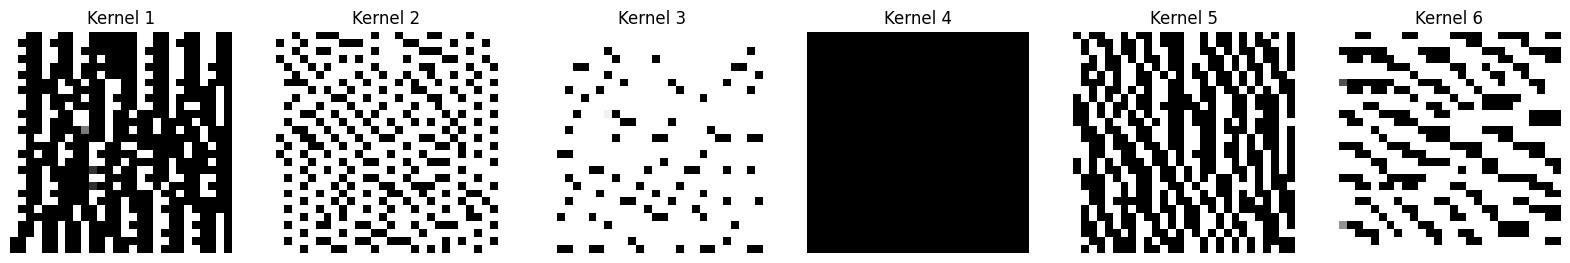

In [84]:
visualize_activations(model, "conv1")

100%|██████████| 200/200 [00:00<00:00, 500.67it/s]


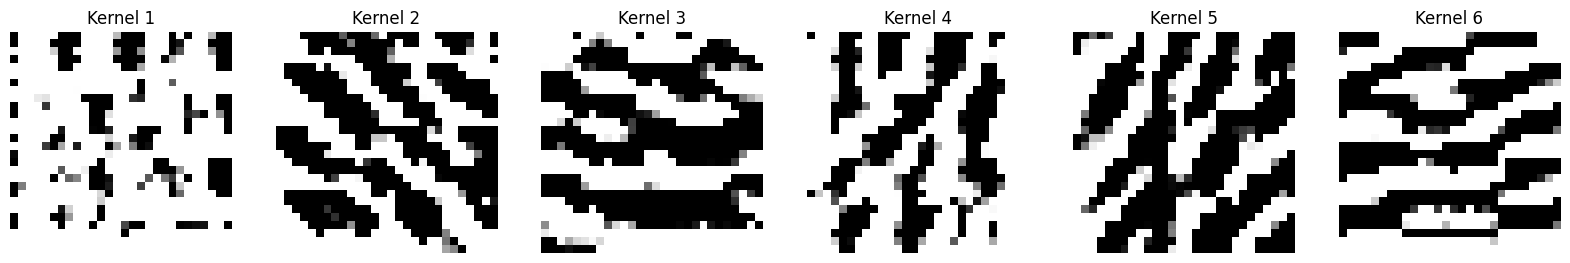

In [85]:
visualize_activations(model, "conv2")

In [87]:
data_loader_test_number, data_loader_test_pattern = load_pure_number_pattern_data(10, is_train=False)

In [88]:
data_loader_test_number

In [117]:
def hook_fn(module, input, output, activations):
    activations.append(output)

def average_activations_for_class(model, data_loader, target_class, layer_name, handles=None):
    activations = []
    handle = dict(model.named_children())[layer_name].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, activations))
    if handles is not None:
        handles.append(handle)
    for inputs, labels in tqdm(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        mask = labels == target_class
        if mask.sum() == 0:
            continue
        with t.no_grad():
            model(inputs[mask])
    handle.remove()
    avg_activations = t.cat(activations, dim=0).mean(dim=0)
    return avg_activations.cpu().numpy(), handle

def visualize_all_classes(model, data_loader, layer_name):
    unique_labels = list(set([label.item() for _, labels in data_loader for label in labels]))
    # Temporary activation to find the number of kernels
    temp_activations, _ = average_activations_for_class(model, data_loader, unique_labels[0], layer_name)
    num_kernels = temp_activations.shape[0]
    fig, axes = plt.subplots(len(unique_labels), num_kernels, figsize=(num_kernels * 2, len(unique_labels) * 2))
    handles = []
    for idx, class_label in enumerate(unique_labels):
        # The modification here is to capture the handle from the average_activations_for_class function
        avg_activations, handle = average_activations_for_class(model, data_loader, class_label, layer_name, handles)
        for i in range(num_kernels):
            if len(unique_labels) > 1:
                ax = axes[idx, i]
            else:
                ax = axes[i]
            ax.imshow(avg_activations[i], cmap='gray')
            ax.axis('off')
            if idx == 0:
                ax.set_title(f'Kernel {i + 1}')
        if len(unique_labels) > 1:
            axes[idx, 0].set_ylabel(f'Class {class_label}', size='large')
    plt.tight_layout()
    plt.show()
    for handle in handles:
        handle.remove()



100%|██████████| 157/157 [00:02<00:00, 63.45it/s]


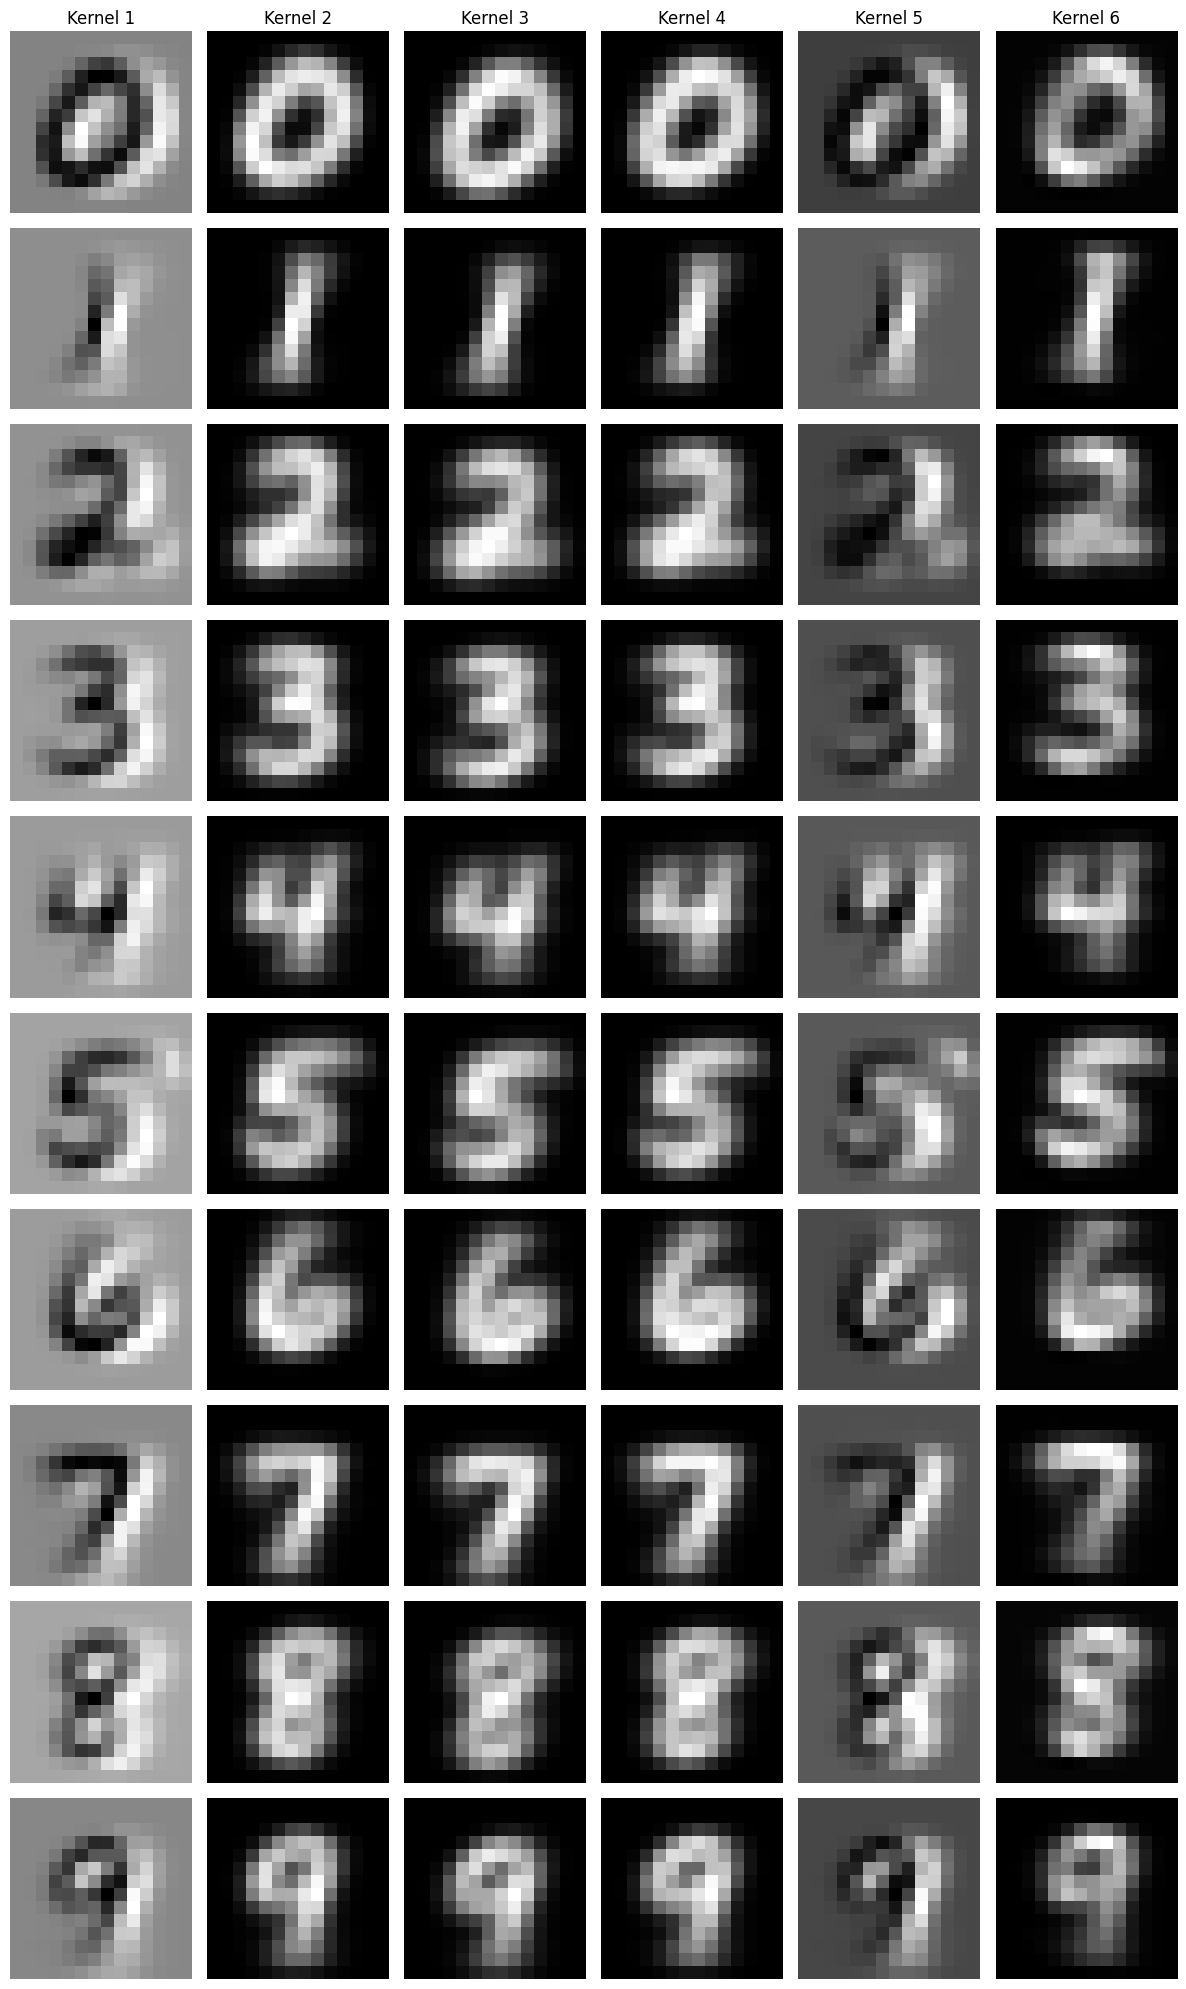

In [118]:
visualize_all_classes(model, data_loader_test_number, "conv1")

100%|██████████| 157/157 [00:02<00:00, 61.61it/s]


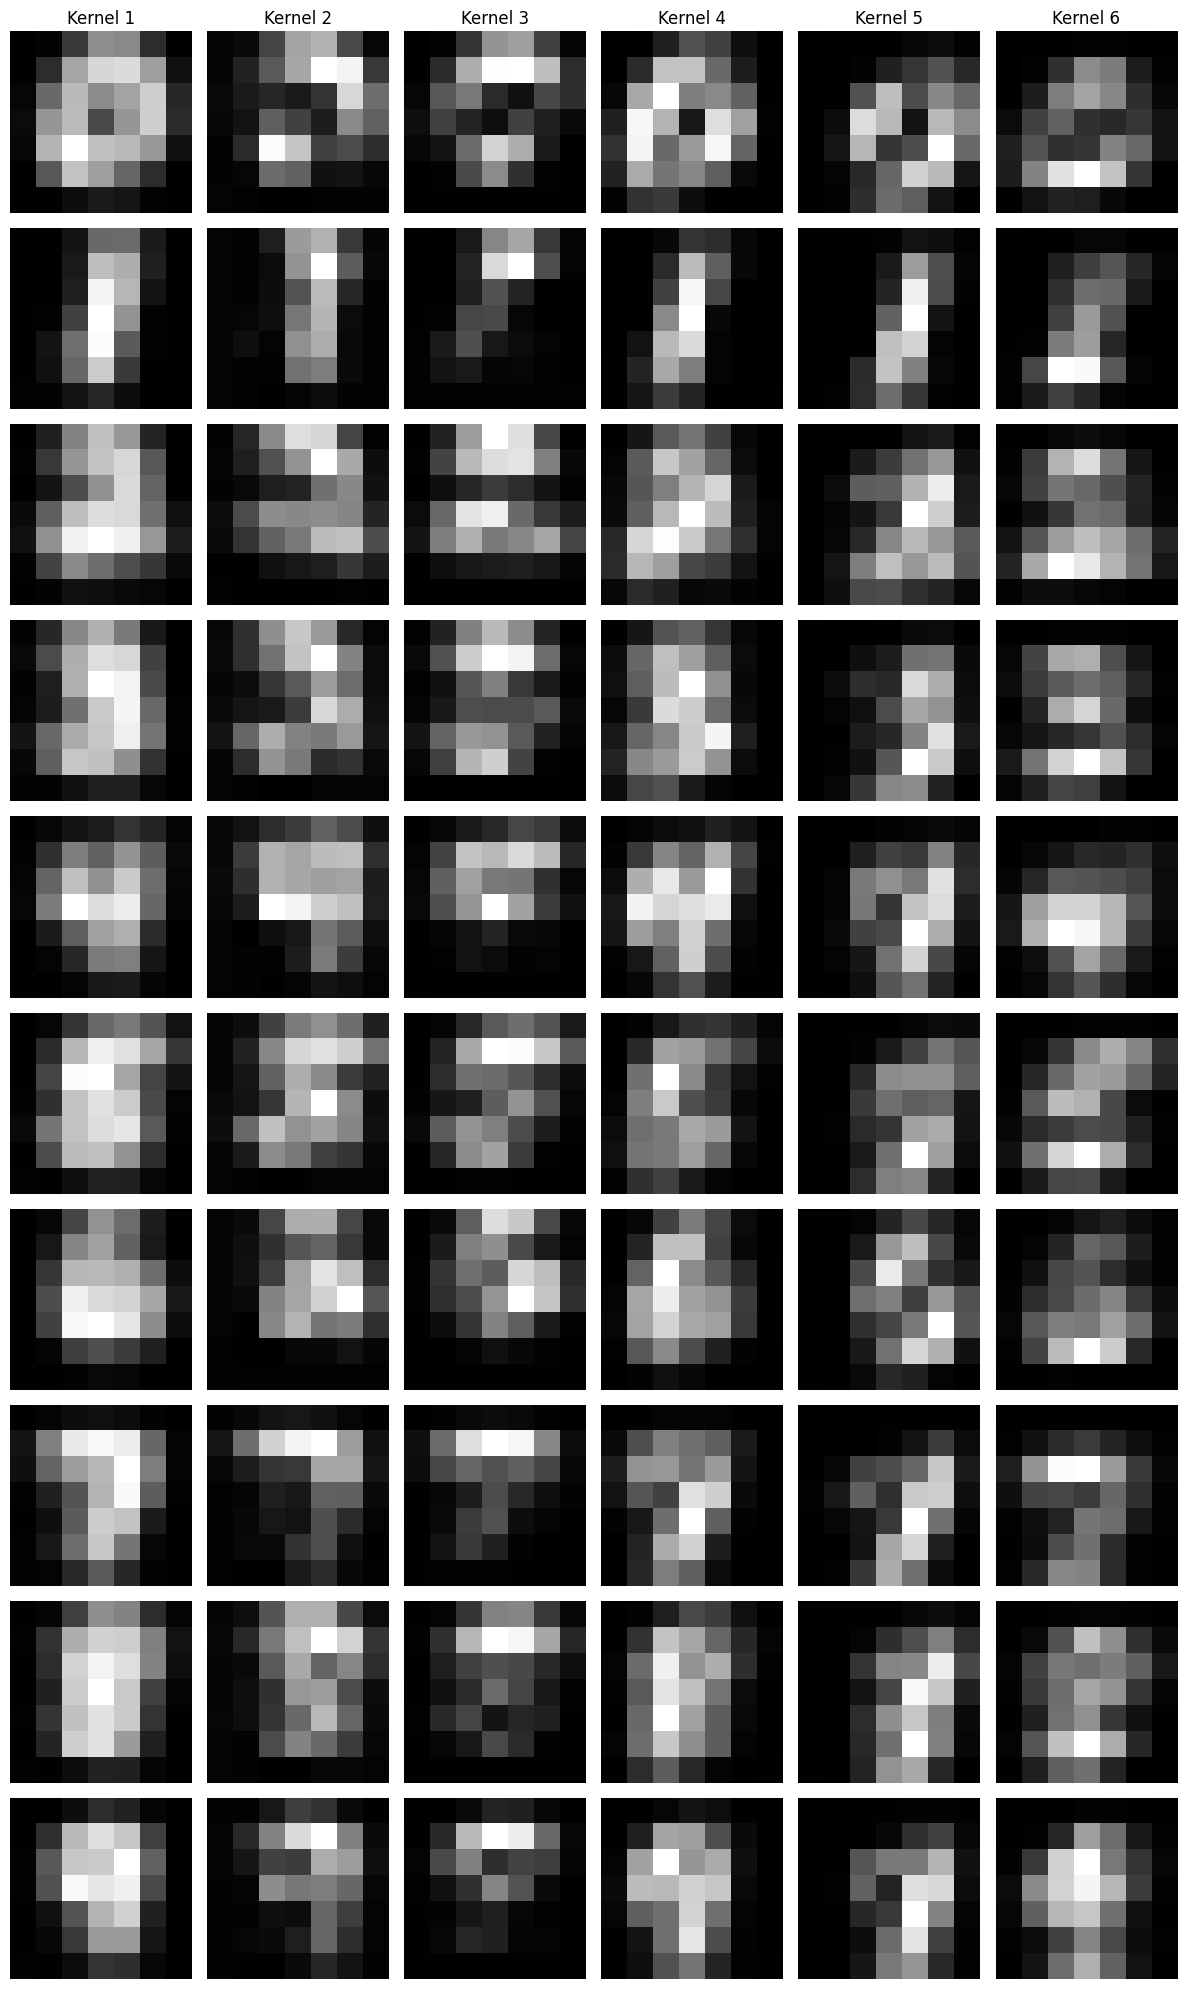

In [119]:
visualize_all_classes(model, data_loader_test_number, "conv2")

100%|██████████| 157/157 [00:02<00:00, 64.46it/s]


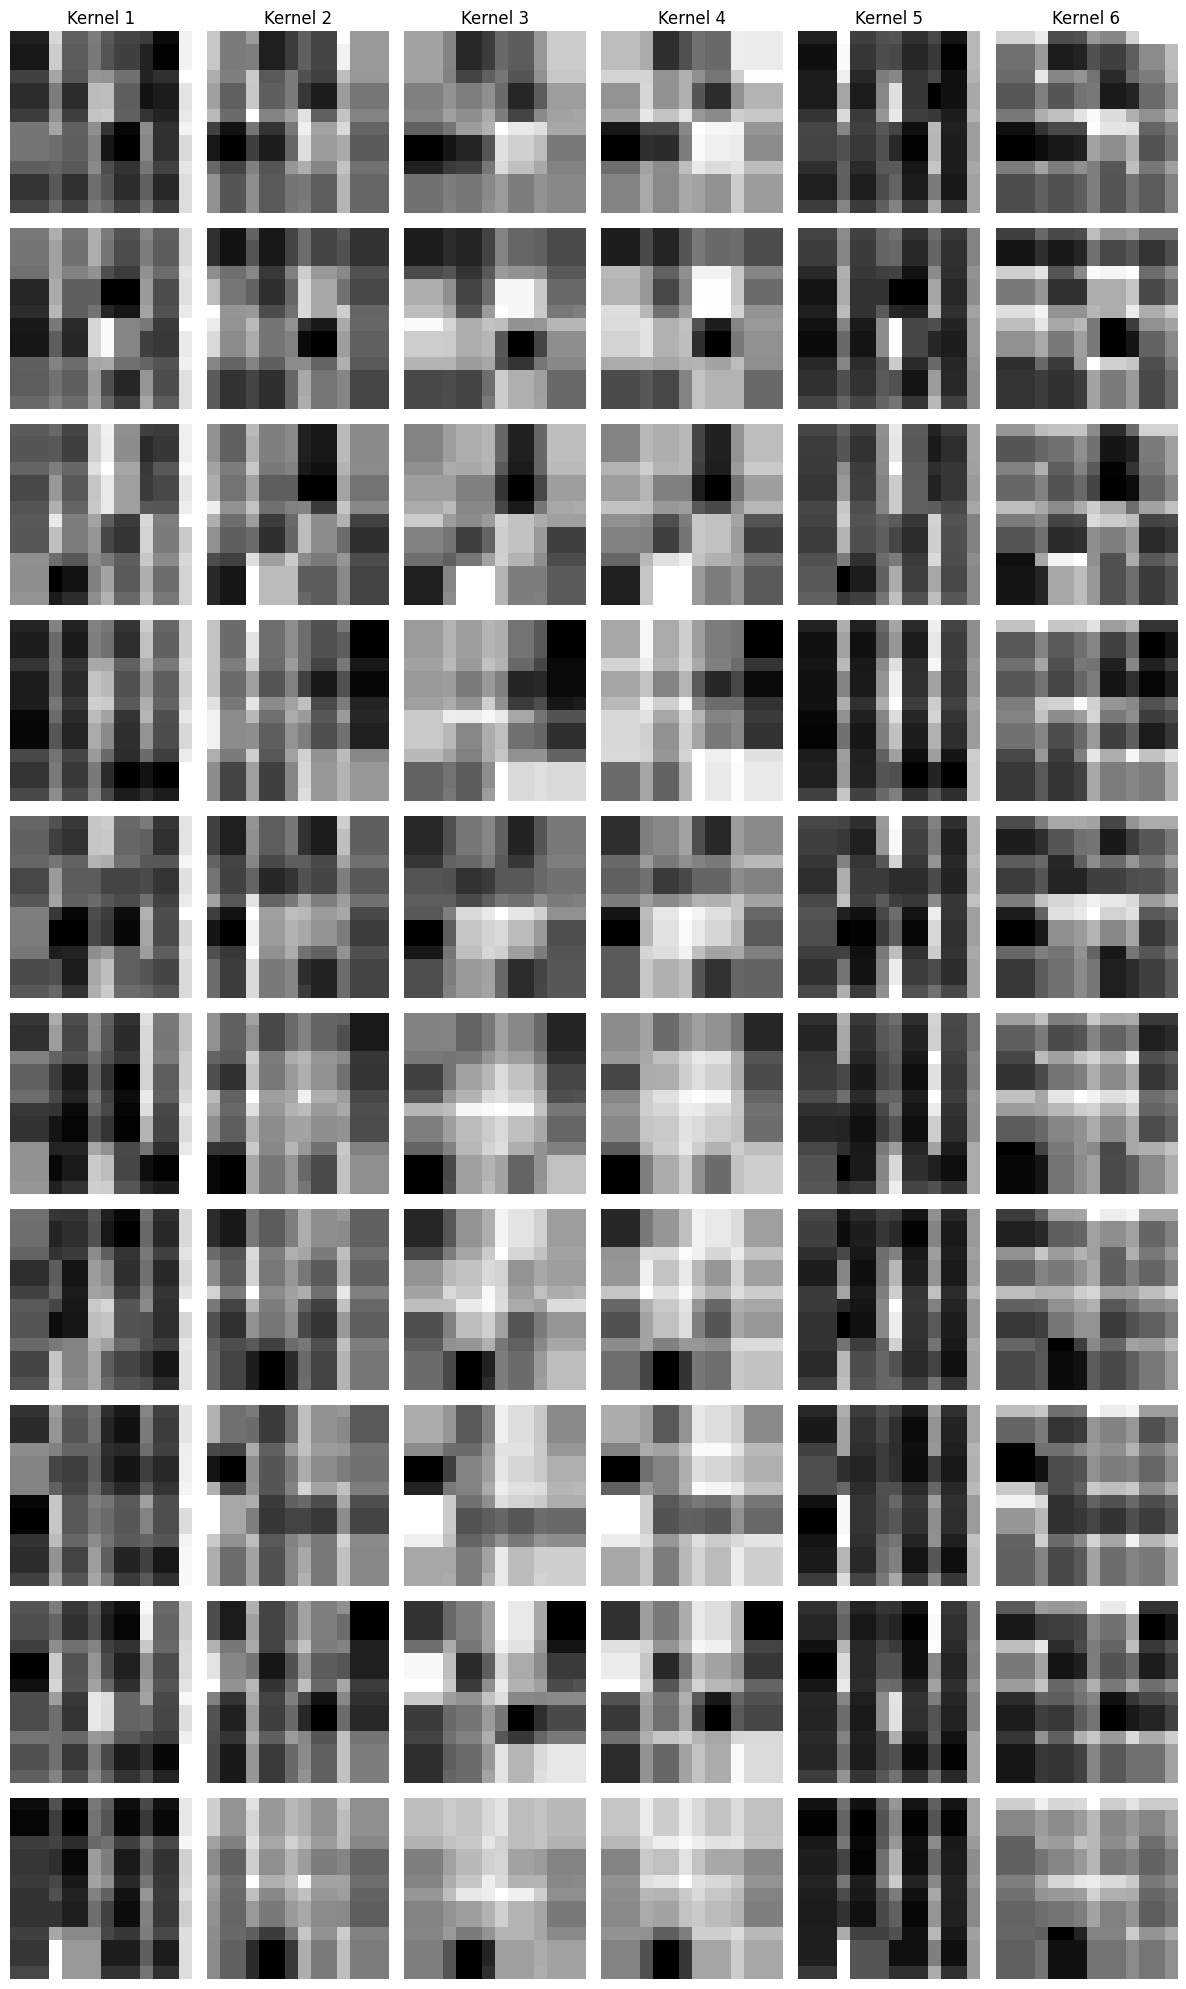

In [121]:
visualize_all_classes(model, data_loader_test_pattern, "conv1")

100%|██████████| 157/157 [00:02<00:00, 66.98it/s]


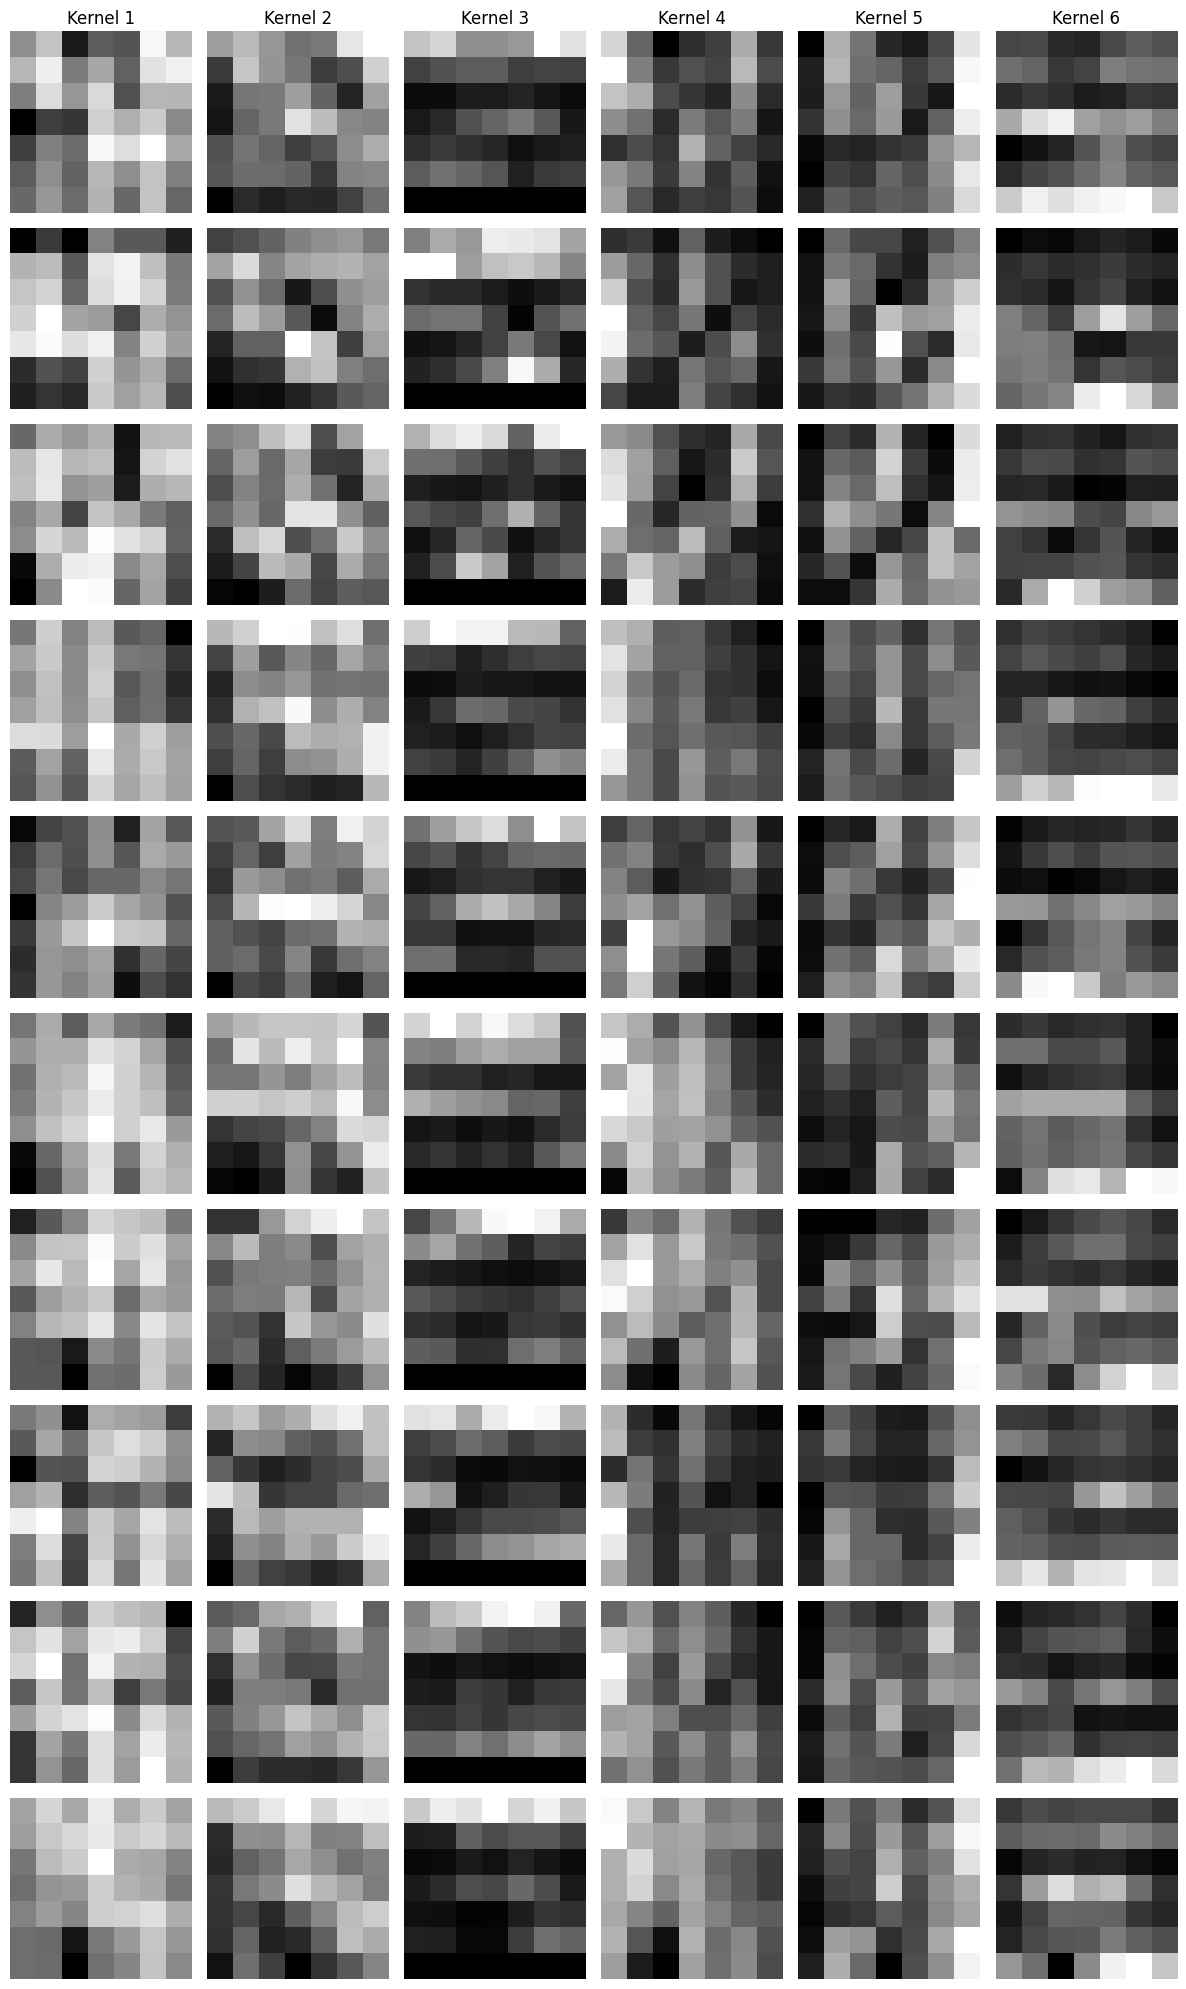

In [123]:
visualize_all_classes(model, data_loader_test_pattern, "conv2")